In [112]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


<div style="background-color: #6BA3B9; padding: 20px; font-size: 18px; text-align: center;">Diabetes Detection with Machine Learning</div>

## Introduction
In this project, we will be building a machine learning model that can predict whether a person has diabetes based on several features such as age, gender, hypertension, heart disease, smoking history, BMI, HbA1c level, and blood glucose level.

## Dataset
We will be using a dataset that contains information about patients, including their medical history and lab results. 

## Goals
Our ultimate goal is to create a machine learning model that accurately predicts diabetes status and can be used by healthcare professionals to identify at-risk individuals and provide early interventions. In this notebook, we will:

* Preprocess the data to prepare it for machine learning.
* Build and train a machine learning model to predict diabetes status.
* Evaluate the performance of our model using various performance metrics.
* Use LIME, Shapley and LOCO to gain insight of how the model works and thus increase explainability

## Load the dataset


In [113]:
df = pd.read_csv('/Users/kevinlandegent/Downloads/diabetes_prediction_dataset.csv')

<div style="background-color: #6BA3B9; padding: 10px; font-size: 18px; text-align: center">Dataset Overview</div>
<p>Our dataset contains information about 100,000 patients, including their medical history and lab results. The dataset has <strong>9 columns</strong>, which are:</p>
<ul>
<li><strong>gender:</strong> The gender of the patient.</li>
<li><strong>age:</strong> The age of the patient in years.</li>
<li><strong>hypertension:</strong> Whether the patient has hypertension (1 = yes, 0 = no).</li>
<li><strong>heart_disease:</strong> Whether the patient has heart disease (1 = yes, 0 = no).</li>
<li><strong>smoking_history:</strong> The patient's smoking history (never, formerly, or currently).</li>
<li><strong>bmi:</strong> The patient's body mass index (BMI).</li>
<li><strong>HbA1c_level:</strong> The patient's HbA1c level.</li>
<li><strong>blood_glucose_level:</strong> The patient's fasting blood glucose level.</li>
<li><strong>diabetes:</strong> Whether the patient has diabetes (1 = yes, 0 = no).</li>
</ul>
<p><strong>The data types of the columns include float64, int64, and object. 
We will need to convert some of the columns to a different data type, such as converting the gender and smoking_history columns to a categorical data type.</strong></p>

# Data-preprocessing

In [114]:
df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df['diabetes'] = df['diabetes'].astype(bool)


In [115]:
# drop duplicates
df.drop_duplicates(inplace=True)

# check for duplicates again
print(df.duplicated().any())

False


<div style="background-color: #6BA3B9; padding: 10px; font-size: 18px; text-align: center">Preprocess the data to prepare it for machine learning.</div>

## one-hot encoding

In [116]:
X = df.drop('diabetes', axis = 1 )
y = df.diabetes
X = pd.get_dummies(X, columns=['smoking_history', 'gender'], drop_first=True)
X = X.drop(['gender_Other', 'smoking_history_not current', 'smoking_history_never', 'smoking_history_ever'], axis=1)

<div style="background-color: #6BA3B9; padding: 10px; font-size: 18px; text-align: center">Split the dataset</div>


In [117]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

<div style="background-color: #f0f0f0; padding: 10px; border-radius: 5px;">
    <h2> The dataset imbalanced </h2>
    <div>
        <p>The target variable 'diabetes' in this dataset is imbalanced, with a majority of 72,480 individuals labeled as 'No Diabetes' and only 5,843 labeled as 'Diabetes'. This means that the dataset contains significantly more examples of one class than the other, which can affect the performance of machine learning algorithms and result in biased predictions. To address this issue, we may need to use techniques such as oversampling, undersampling, or synthetic data generation to balance the dataset and improve the performance of our models.</p>
</div>

<AxesSubplot:title={'center':'count (target)'}>

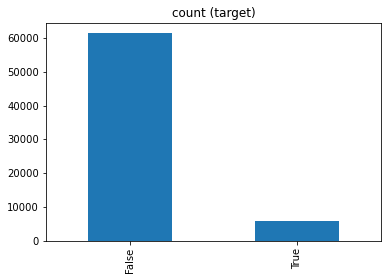

In [118]:
# class count
class_count_0, class_count_1 = y_train.value_counts()
y_train.value_counts().plot(kind='bar', title='count (target)')

In [119]:
# Get the indices of the instances of each class in y_train
indices_majority = y_train[y_train == 0].index
indices_minority = y_train[y_train == 1].index

# Calculate the desired number of samples in the majority class
desired_majority_count = 4 * len(indices_minority)

# Randomly undersample the majority class to get the desired number of samples
undersampled_indices = np.random.choice(indices_majority, size=desired_majority_count, replace=False)

# Combine the undersampled majority indices and the minority indices
balanced_indices = np.concatenate([undersampled_indices, indices_minority])

# Use the balanced_indices to get the balanced X_train and y_train
X_train = X_train.loc[balanced_indices]
y_train = y_train.loc[balanced_indices]

# Build Model & Evaluate

<div style="background-color: #6BA3B9; padding: 10px; font-size: 18px; text-align: center">Build and train a machine learning model to predict diabetes status.</div>



In [120]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline

def report_model(model):
    y_train_repo = model.predict(X_train)
    y_test_repo = model.predict(X_test)
    print(f"the accuracy on train set {accuracy_score(y_train, y_train_repo)}")
    print(f"the accuracy on test set {accuracy_score(y_test, y_test_repo)}")
    print()
    print(classification_report(y_test , y_test_repo))
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_repo)).plot()
    plt.show()

the accuracy on train set 0.9526502963590178
the accuracy on test set 0.9631119123561226

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     26267
        True       0.81      0.76      0.79      2577

    accuracy                           0.96     28844
   macro avg       0.90      0.87      0.88     28844
weighted avg       0.96      0.96      0.96     28844



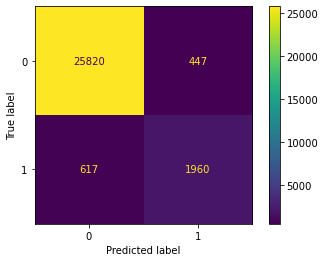

In [121]:
model = XGBClassifier(n_estimators= 100, max_depth = 5, random_state = 42 )
model.fit(X_train, y_train)
report_model(model)

# SMOTE

<div style="background-color: #6BA3B9; padding: 10px; font-size: 18px; text-align: center">balance data with SMOTE
</div>
<div>
        <p>Use Smote to see if this is also a good technique to balance out the data. Again only the training data is balanced.</p>
</div>



the accuracy on train set 0.9433022861981372
the accuracy on test set 0.9672028844820413

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     26267
        True       0.89      0.72      0.80      2577

    accuracy                           0.97     28844
   macro avg       0.93      0.86      0.89     28844
weighted avg       0.97      0.97      0.97     28844



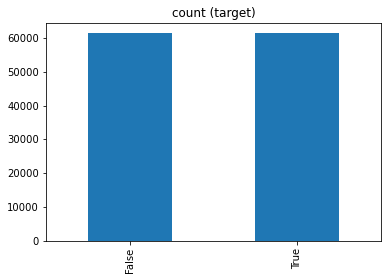

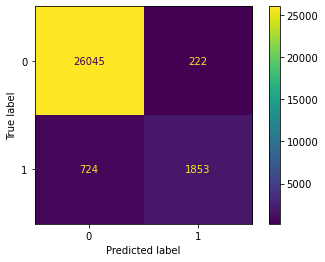

In [122]:
df2 = pd.read_csv('/Users/kevinlandegent/Downloads/diabetes_prediction_dataset.csv')

df2['gender'] = df2['gender'].astype('category')
df2['smoking_history'] = df2['smoking_history'].astype('category')
df2['hypertension'] = df2['hypertension'].astype(bool)
df2['heart_disease'] = df2['heart_disease'].astype(bool)
df2['diabetes'] = df2['diabetes'].astype(bool)

# drop duplicates
df2.drop_duplicates(inplace=True)

X_SMOTE = df2.drop('diabetes', axis = 1 )
y_SMOTE = df2.diabetes
X_SMOTE = pd.get_dummies(X_SMOTE, columns=['smoking_history', 'gender'], drop_first=True)
X_SMOTE = X_SMOTE.drop(['gender_Other', 'smoking_history_not current', 'smoking_history_never', 'smoking_history_ever'], axis=1)

X_SMOTE_train, X_SMOTE_test, y_SMOTE_train , y_SMOTE_test = train_test_split(X_SMOTE, y_SMOTE, test_size = 0.3, random_state = 42)

from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X_SMOTE_train, y_SMOTE_train = oversample.fit_resample(X_SMOTE_train, y_SMOTE_train)

y_SMOTE_train.value_counts().plot(kind='bar', title='count (target)')


model_SMOTE = XGBClassifier(n_estimators= 100, max_depth = 5, random_state = 42 )
model_SMOTE.fit(X_SMOTE_train, y_SMOTE_train)
report_model(model_SMOTE)

<div>
        <p>although SMOTE has a slightly better performance on the test set. But the difference is so small that the undersampling method is still preferred since that method doesn't create synthetic samples which might not be representative for real world cases.</p>
</div>



# LIME

In [64]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['negative', 'positive'],
    mode='classification'
)

In [65]:
def return_weights(exp):
    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight

In [66]:
weights = []

#Iterate over first 100 rows in feature matrix
for x in X_test.values[0:100]:
    
    #Get explanation
    exp = explainer.explain_instance(
        data_row=x, 
        predict_fn=model.predict_proba
    )
    
    #Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)
    
#Create DataFrame
lime_weights = pd.DataFrame(data=weights,columns=X_test.columns)

Text(0.5, 0, 'Mean |Weight|')

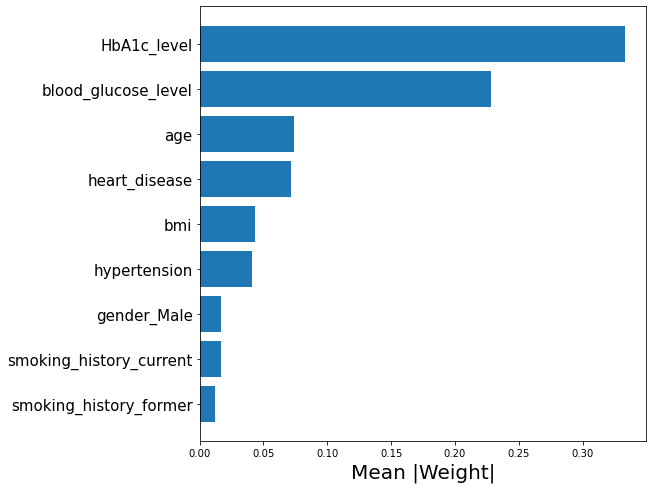

In [67]:
#Get abs mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

#Plot abs mean
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature
plt.barh(y=y_ticks,width=abs_mean.abs_mean)

plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
plt.title('')
plt.ylabel('')
plt.xlabel('Mean |Weight|',size=20)

In [68]:
import shap

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X[0:100])

#Replace SHAP values with LIME weights
shap_placeholder = explainer(X[0:100])
shap_placeholder.values = np.array(lime_weights)

Text(0.5, 0, 'LIME value')

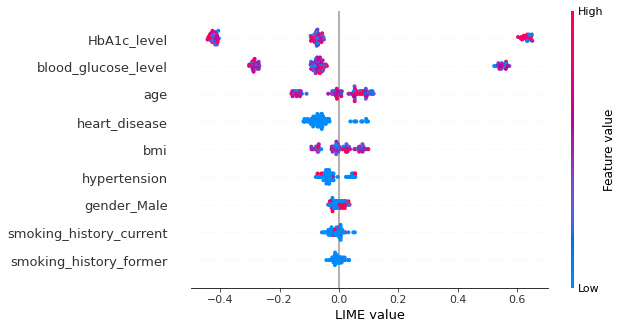

In [69]:
shap.plots.beeswarm(shap_placeholder, show=False)
plt.xlabel('LIME value')

# LOCO

In [70]:
cols = ['feature ommited', 'accuracy train', 'accuracy test', 'ROC AUC']
df = pd.DataFrame(columns=cols)
from sklearn import metrics

for x in X.columns:
    X_temp = X.drop(x, axis = 1)
    X_train, X_test, y_train , y_test = train_test_split(X_temp, y, test_size = 0.3, random_state = 42)

    model = XGBClassifier(n_estimators= 100, max_depth = 5,  scale_pos_weight =  5 , random_state = 42 )
    model.fit(X_train, y_train)
    y_train_repo = model.predict(X_train)
    y_test_repo = model.predict(X_test)
    train_accu = accuracy_score(y_train, y_train_repo)
    test_accu = accuracy_score(y_test, y_test_repo)
    auc = metrics.roc_auc_score(y_test, y_test_repo)
    df = df.append({'feature ommited': x, 'accuracy train' : train_accu, 'accuracy test' : test_accu, 'ROC AUC' : auc},ignore_index=True)

df

,feature ommited,accuracy train,accuracy test,ROC AUC
0,age,0.869303,0.865550,0.865543
1,hypertension,0.908630,0.903522,0.903518
2,heart_disease,0.909198,0.905684,0.905679
3,bmi,0.890608,0.889719,0.889713
4,HbA1c_level,0.831512,0.826694,0.826685
5,blood_glucose_level,0.848313,0.842659,0.842651
6,smoking_history_current,0.906903,0.903669,0.903665
7,smoking_history_former,0.908756,0.903277,0.903272
8,gender_Male,0.908209,0.904112,0.904107


# SHAP

11       54.70
24       13.99
39       56.43
59       63.48
93       55.61
         ...  
99933    13.34
99948    39.62
99953    60.52
99960    45.15
99993    40.69
Name: bmi, Length: 7086, dtype: float64


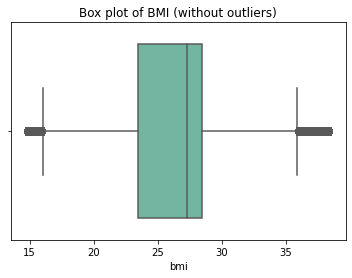

False


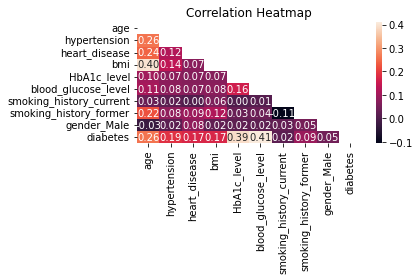

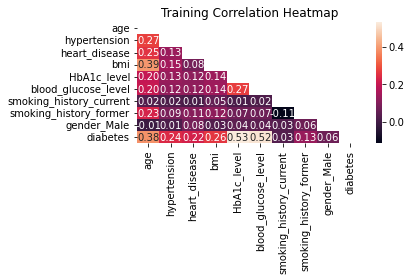

the accuracy on train set 0.9605753862546617
the accuracy on test set 0.9622164832697058

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     16439
        True       0.74      0.78      0.76      1373

    accuracy                           0.96     17812
   macro avg       0.86      0.88      0.87     17812
weighted avg       0.96      0.96      0.96     17812



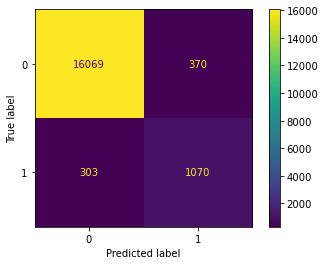

  0%|          | 0/50 [00:00<?, ?it/s]

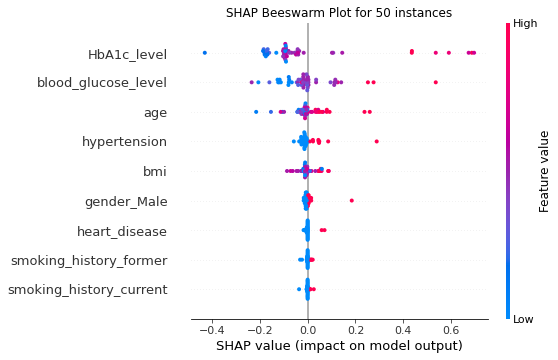

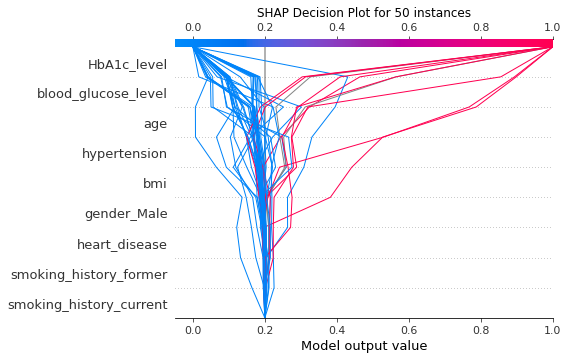

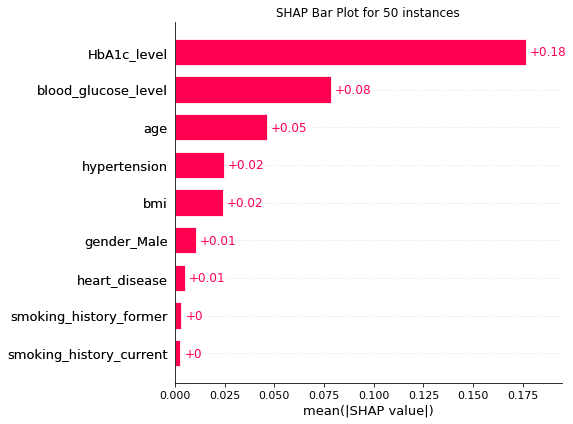

Runtime: 9.79s


In [124]:
import time

sns.set_palette('Set2')
pd.options.plotting.backend = 'plotly'

# ignore warnings
import warnings

# Record the starting time
start_time = time.time()

random_state = 42
warnings.filterwarnings('ignore')

df = pd.read_csv('diabetes_prediction_dataset.csv')

Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = df['bmi'].where(df['bmi'] >= Q1 - 1.5 * IQR).dropna().min()
upper_whisker = df['bmi'].where(df['bmi'] <= Q3 + 1.5 * IQR).dropna().max()

outliers = df[(df['bmi'] < lower_whisker) | (df['bmi'] > upper_whisker)]
print(outliers['bmi'])

# calculate the IQR
Q1 = np.percentile(df['bmi'], 25)
Q3 = np.percentile(df['bmi'], 75)
IQR = Q3 - Q1

# determine the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove the outliers
df = df[(df['bmi'] >= lower_bound) & (df['bmi'] <= upper_bound)]

# plot the boxplot for BMI
sns.boxplot(df['bmi'])
plt.title('Box plot of BMI (without outliers)')
plt.savefig('boxplot_XGBC.png')
plt.show()

df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df['diabetes'] = df['diabetes'].astype(bool)

# drop duplicates
df.drop_duplicates(inplace=True)

# check for duplicates again
print(df.duplicated().any())

X = df.drop('diabetes', axis=1)
y = df.diabetes
X = pd.get_dummies(X, columns=['smoking_history', 'gender'], drop_first=True)
X = X.drop(['gender_Other', 'smoking_history_not current', 'smoking_history_never', 'smoking_history_ever'], axis=1)

# Correlation Heatmap
corr = pd.concat([X, y], axis=1).corr()

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title(f'Correlation Heatmap')
plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

class_count_0, class_count_1 = y_train.value_counts()
y_train.value_counts().plot(kind='bar', title='count (target)')
plt.show()

# Get the indices of the instances of each class in y_train
indices_majority = y_train[y_train == 0].index
indices_minority = y_train[y_train == 1].index

# Calculate the desired number of samples in the majority class
desired_majority_count = 4 * len(indices_minority)

# Randomly undersample the majority class to get the desired number of samples
undersampled_indices = np.random.choice(indices_majority, size=desired_majority_count, replace=False)

# Combine the undersampled majority indices and the minority indices
balanced_indices = np.concatenate([undersampled_indices, indices_minority])

# Use the balanced_indices to get the balanced X_train and y_train
X_train = X_train.loc[balanced_indices]
y_train = y_train.loc[balanced_indices]

# Correlation Heatmap
corr = pd.concat([X_train, y_train], axis=1).corr()

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title(f'Training Correlation Heatmap')
plt.tight_layout()
plt.savefig("heatmap_train.png")
plt.show()

model = XGBClassifier(n_estimators=100, random_state=random_state)
model.fit(X_train, y_train)
cv = 5
weights = [2, 3, 25, 50, 100, 500]

y_train_repo = model.predict(X_train)
y_test_repo = model.predict(X_test)
print(f"the accuracy on train set {accuracy_score(y_train, y_train_repo)}")
print(f"the accuracy on test set {accuracy_score(y_test, y_test_repo)}")
print()
print(classification_report(y_test, y_test_repo))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_repo)).plot()
plt.savefig('confmatrix_XGBC.png')
plt.show()

# Compute SHAP values and plot summary
samples = 50
X_shap = shap.sample(X_train, samples, random_state=random_state)
mask = shap.maskers.Independent(X_train, max_samples=1000)
explainer = shap.KernelExplainer(model.predict, X_shap, masker=mask)

shap_values = explainer.shap_values(X_shap)

explanation = shap.Explanation(shap_values, data=X_shap,
                               feature_names=X_train.columns)

shap.plots.beeswarm(explanation, show=False)
plt.title(f'SHAP Beeswarm Plot for {samples} instances')
plt.tight_layout()
plt.savefig('beeswarm_SHAP.png')
plt.show()

shap.decision_plot(explainer.expected_value, shap_values,
                   feature_names=list(X_train.columns), xlim=(-0.05, 1), show=False)
plt.title(f'SHAP Decision Plot for {samples} instances')
plt.tight_layout()
plt.savefig('dec_SHAP.png')
plt.show()

shap.plots.bar(explanation, show=False)
plt.title(f'SHAP Bar Plot for {samples} instances')
plt.tight_layout()
plt.savefig('bar_SHAP.png')
plt.show()

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the runtime in seconds
print(f"Runtime: {elapsed_time:.2f}s")